# Анализ успешности игр.


Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Наша цель - выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
pd.set_option('display.float_format', '{:,.2f}'.format)

## Открытие таблицы и изучение общей информации о данных

In [2]:
df = pd.read_csv('/datasets/games.csv')
display(df.head())
df.info()
display(df.describe())
print('Дубликатов:', df.duplicated().sum())

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,"2,006.00",Sports,41.36,28.96,3.77,8.45,76.00,8,E
1,Super Mario Bros.,NES,"1,985.00",Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,"2,008.00",Racing,15.68,12.76,3.79,3.29,82.00,8.3,E
3,Wii Sports Resort,Wii,"2,009.00",Sports,15.61,10.93,3.28,2.95,80.00,8,E
4,Pokemon Red/Pokemon Blue,GB,"1,996.00",Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,"16,446.00","16,715.00","16,715.00","16,715.00","16,715.00","8,137.00"
mean,"2,006.48",0.26,0.15,0.08,0.05,68.97
std,5.88,0.81,0.50,0.31,0.19,13.94
min,"1,980.00",0.00,0.00,0.00,0.00,13.00
25%,"2,003.00",0.00,0.00,0.00,0.00,60.00
50%,"2,007.00",0.08,0.02,0.00,0.01,71.00
75%,"2,010.00",0.24,0.11,0.04,0.03,79.00
max,"2,016.00",41.36,28.96,10.22,10.57,98.00


Дубликатов: 0


In [3]:
# Определим, почему колонка User_Score имеет тип string
df['User_Score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

**Вывод**

При изучении общей информации о данных были обнаружены следующие проблемы:
- Названия столбцов не соответствуют общепринятым нормам.
- Данные в колонкае Year_of_Release имеют тип float, но по смыслу, имеют только целочисленные значения.
- Данные в колонке User_Score числовые, но имеют тип object. В данной колонке, кроме цифровых значений, присутствует строковое значение 'tbd'.
- Имеются пропуски в колонках Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating.

## Подготовка данных

На данном этапе, произведём подготовку данных для дальнейшего анализа:
- Произведём переименование колонок(приведём к нижнему регистру);
- Преобразуем данные в нужные типы:
    - колонку Year_of_Release преобразуем в int64
    - колонку User_Score необходимо привести к типу данных float. Но прежде, надо разобраться со строковым значением 'tbd'.
- Обработаем пропуски в колонках Name, Year_of_Release, Genre, Critic_Score, User_Score, Rating. 
- Произведём расчёт суммарных продаж во всех регионах.

### Переименование колонок

In [4]:
# Переименование колонок
#df.columns = ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
#              'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']
df.columns = df.columns.str.lower()

df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

**Вывод**

Произведено переименование колонок.

### Преобразование типов данных

- В колонке Year_of_Release содержется информация о годе выпуска игры. Год - целочисленное значение, поэтому преобразуем тип данных в int64.
- В колонке User_Score разберёмся со значением tbd, затем преобразуем в тип float.

In [5]:
df['year_of_release'] = df['year_of_release'].astype(pd.Int64Dtype())
#df['critic_score'] = df['critic_score'].astype(pd.Int64Dtype())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.4+ MB


Аббревиатура 'tbd' в игровой сфере ознаяает 'To Be Determined' - 'Будет определено'. Следовательно, значения ещё не определены, а значит их необходимо заменить на NaN. Затем, для дальнейшей обработки, преобразуем тип данных в столбце user_score в тип float.

In [6]:
# Замена 'tbd' на NaN
df.loc[df['user_score'] == 'tbd', 'user_score'] = np.NaN
# Преобразование типа данных
df['user_score'] = df['user_score'].astype('float64')
df['user_score'].unique()

array([8. , nan, 8.3, 8.5, 6.6, 8.4, 8.6, 7.7, 6.3, 7.4, 8.2, 9. , 7.9,
       8.1, 8.7, 7.1, 3.4, 5.3, 4.8, 3.2, 8.9, 6.4, 7.8, 7.5, 2.6, 7.2,
       9.2, 7. , 7.3, 4.3, 7.6, 5.7, 5. , 9.1, 6.5, 8.8, 6.9, 9.4, 6.8,
       6.1, 6.7, 5.4, 4. , 4.9, 4.5, 9.3, 6.2, 4.2, 6. , 3.7, 4.1, 5.8,
       5.6, 5.5, 4.4, 4.6, 5.9, 3.9, 3.1, 2.9, 5.2, 3.3, 4.7, 5.1, 3.5,
       2.5, 1.9, 3. , 2.7, 2.2, 2. , 9.5, 2.1, 3.6, 2.8, 1.8, 3.8, 0. ,
       1.6, 9.6, 2.4, 1.7, 1.1, 0.3, 1.5, 0.7, 1.2, 2.3, 0.5, 1.3, 0.2,
       0.6, 1.4, 0.9, 1. , 9.7])

**Вывод**
- Изменили тип данных в колонке year_of_release;
- Преобразовати tbd в NaN и преобразовали тип данных во float/


### Обработка пропусков

Обработаем пропуски в колонках 
- Name, Genre: посмотрим на данные и примем решение;

- Rating: заполним пропуски занчением unknown.
- Year_of_Release: одни и тежи игры на разных платформах, могут выходить в разные годы. Поэтому, восстановить эти данные не получится. Оставим эти пропуски без заполнения;
- Critic_Score, User_Score: неоткуда взять, оставим как есть. В старых играх ещё нет оценок, в новых не указаны.

#### Обработка пропусков в колонках Name, Genre.

In [7]:
display(df[df['name'].isna()])
df[df['genre'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [8]:
# Удалим две неинформативные строки
df = df.dropna(subset=['name'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


**Вывод:**
Удалили всего 2 неинформативные строки.

#### Обработка пропусков в колонке rating.

Для дальнейшего анализа, заполним пропуски занчением unknown.

In [9]:
df['rating'] = df['rating'].fillna('unknown')
df['rating'].value_counts()

unknown    6764
E          3990
T          2961
M          1563
E10+       1420
EC            8
RP            3
K-A           3
AO            1
Name: rating, dtype: int64

**Вывод:**
Заменили пропуски на unknown.

**Вывод**

Обработали пропуски в колонках:

- Name, Genre: удалили 2 неинформативные строки;
- Rating: заполнили пропуски занчением unknown.
- Year_of_Release, Critic_Score, User_Score, Rating: оставили как есть, так как восстановить данные неоткуда, а удалив, потеряем много нужной информации.


### Расчёт суммарных продаж во всех регионах

Для дальнейшего анализа понадобятся данные об общих продажах игры по всем регионам. Произведём рассчёт и добавим данные в новую колонку summ_sales.

In [10]:
df['summ_sales'] = df[['na_sales','eu_sales','jp_sales','other_sales']].apply(sum, axis=1)

In [11]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,summ_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.00,8.00,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.00,8.30,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.00,8.00,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           16713 non-null  object 
 11  summ_sales       16713 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.7+ MB


**Вывод**

Произведн расчёт суммарных продаж и данные добавлены в датафрейм.

**Вывод по разделу**

В данном разделе произведена подготовка данных к дальнейшему анализу:
- Переименованы колонки в соответствии с общепринятыми номами;
- Преобразованы типы данных в колонках year_of_release, user_score в соответствии с их содержанием;
- Обработаны пропуски:
    - В колонке name, genre - принято решение удалить две строки с пропусками в данных колонках, так как это не окажет существенного влияния на качество данных. Наиболее вероятная причина данных пропусков - ошибка при введении данных;
    - year_of_release, critic_score, user_score, rating - пропуски не заполнены, так как информацию восстановить неоткуда. Удалять данные пропуски не целесообразно, так как удалится большой объём данных, что может негативно сказаться на качестве дальнейшего анализа. Наиболее вероятная причина данных пропусков - для игр выпущеных раньше 1994 года - рейтинги ещё не составлялись. Для более поздних игр - либо рейтинг просто не попал в таблицу на этапе ввода данных, либо данная игра не оценивалась ESRB.
- Произведён расчёт суммарных продаж во всех регионах и добавлена колонна с этими данными.


## Исследовательский анализ данных

В ходе исследовательского анализа данных произведём:

- Анализ игр по годам выхода. Определим важны ли данные за все периоды;
- Анализ продаж по игровым платформам. Определим за какой характерный срок появляются новые и исчезают старые платформы. Определим актуальный период, данные в котором помогут построить прогноз на 2017 год;
- Анализ платформ по продажам. Выберем несколько потенциально прибыльных платформ.

- Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.
- Соотнесите выводы с продажами игр на других платформах.
- Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

### Анализ игр по годам выхода.

Посмотрим, сколько игр выпускалось в разные годы. Для этого построим график зависимости количества выпускаемых игр по годам. Определим важны ли данные за все периоды;



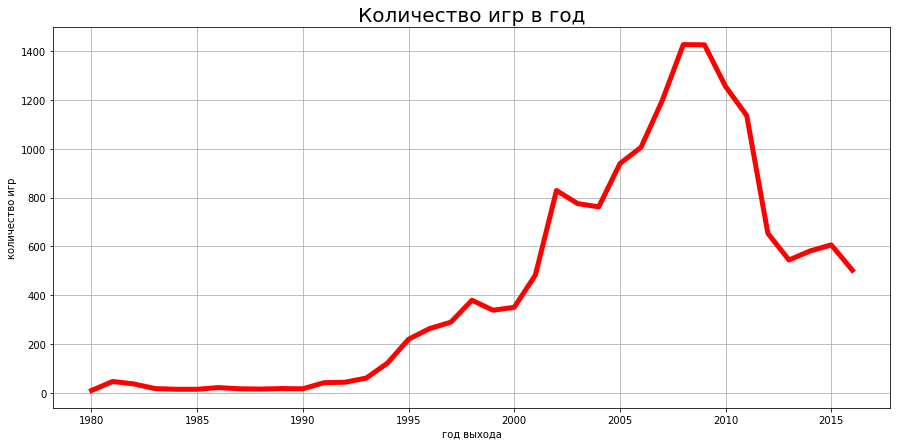

In [13]:
# Рассчитаем с помощью сводной таблицы количество игр в год и нарисуем график
ax = (df.pivot_table(index  ='year_of_release', 
                     values ='name', 
                     aggfunc='count').
    plot(color    ='red',
         linewidth=5,
         grid     =True,
         figsize  =(15,7),
         legend=False))
ax.set(ylabel='количество игр',
       xlabel= 'год выхода')
ax.set_title('Количество игр в год', fontsize=20)
plt.show;

**Вывод**

C 1980 по 1993 год, игровая индустрия только зарождалась. В год выходило в среднем 35 игр. 
Начиная с 1994 года популярность игр начала возрастать, и к 2008 году достигла пика в 1441 игру в год. Дальше начался спад количества игрдо 500 в год в 2016 году.

Из полученных данных очевидно, что для порогноза на 2017 год, данные, ориентировачно, до 1995 года нам не помогут. Более точно актуальный период для дальнейшего анализа определим в следующем разделе.

### Анализ игровых платформ.

Проанализируем, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и пострим распределение по годам. Определим за какой характерный срок появляются новые и исчезают старые платформы?

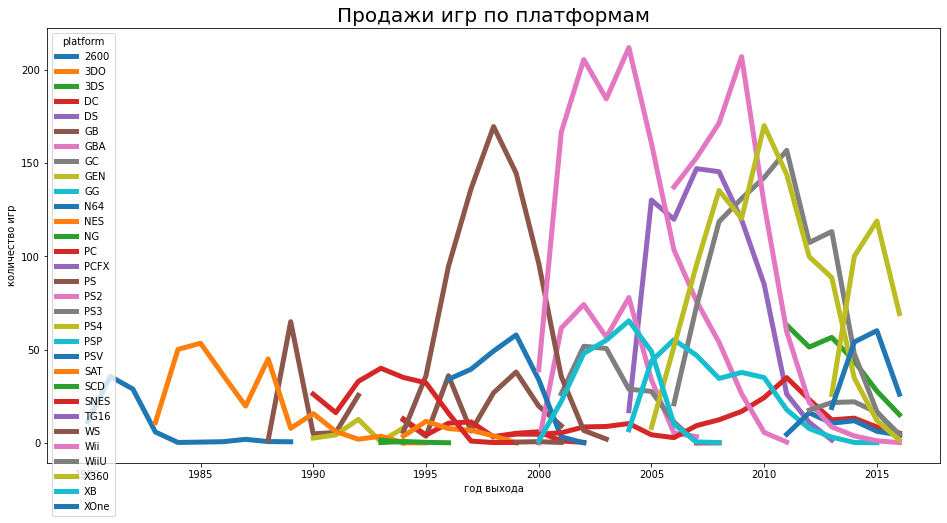

In [14]:
# Все платформы по годам
ax = (df.pivot_table(index='year_of_release', 
               columns='platform', 
               values='summ_sales', 
               aggfunc='sum').
    plot(linewidth=5, 
         figsize=(16,8)))
ax.set(ylabel='количество игр',
       xlabel= 'год выхода')
ax.set_title('Продажи игр по платформам', fontsize=20)
plt.show;

Данный график распределения сложно анализировать. Выделим из общей массы платформы с наибольшими продажами.

In [15]:
# Определим платформы с максимальными продажами
df_max_sales_platform = df.groupby('platform')['summ_sales'].agg('sum').sort_values(ascending=False).head(10)
df_max_sales_platform

platform
PS2    1,255.77
X360     971.42
PS3      939.65
Wii      907.51
DS       806.12
PS       730.86
GBA      317.85
PS4      314.14
PSP      294.05
PC       259.52
Name: summ_sales, dtype: float64

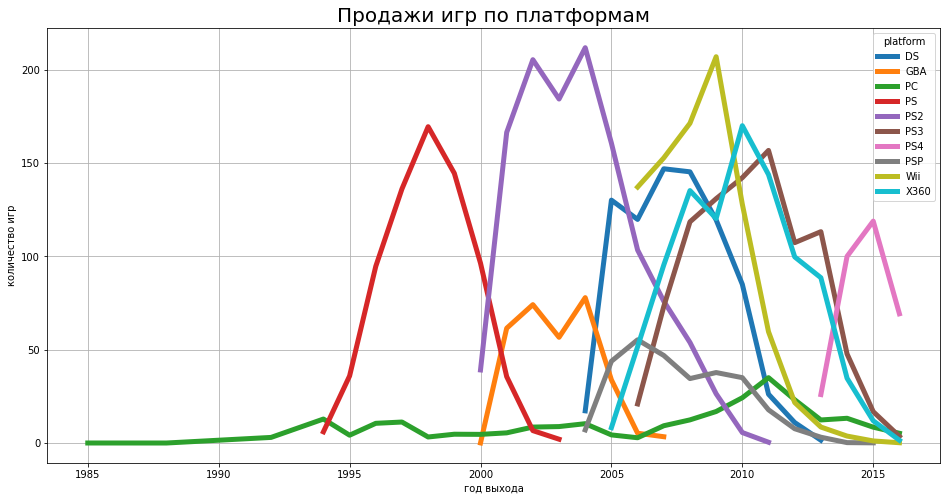

In [16]:
# Продажи игр на платформах с максимальными продажами по годам
ax= (df.query('platform in @df_max_sales_platform.index').
             pivot_table(index  ='year_of_release', 
                         columns='platform', 
                         values ='summ_sales', 
                         aggfunc='sum').
             plot(linewidth=5, 
                  figsize=(16,8),
                 grid=True))
ax.set(ylabel='количество игр',
       xlabel= 'год выхода')
ax.set_title('Продажи игр по платформам', fontsize=20)
plt.show;

In [17]:
# Время жизни одной игорвой платформы
(df.query('platform in @df_max_sales_platform.index').
             pivot_table(index  ='year_of_release', 
                         columns='platform', 
                         values ='summ_sales', 
                         aggfunc='sum')).notna().sum()

platform
DS      11
GBA      8
PC      26
PS      10
PS2     12
PS3     11
PS4      4
PSP     12
Wii     11
X360    12
dtype: int64

**Вывод**

Время жизни наиболее популярных платформ составляет 10-13 лет. Из данного правила выбивается только платформа PC - она присутствует с зарождения игровой индустрии. 

### Определение актуальных данных.

Для дальнейшего анализа по построению прогноза на 2017, возьмём только актуальные данные. 
- За актуальный период примем 4 года. Данные за более ранний период, не помогут построить прогноз на 2017 год, так как игровых платформ из более далёкого прошлого уже не существует. 
- Исключим из дальнейшего анализа игровые платформы, которые есть в определнном актуальном периоде, но которые к 2016 году уже потеряли актуальность.

In [18]:
# Составим споисок игровых платформ, актуальных на 2016 год
actual_platforms = list(df.query('year_of_release == 2016')['platform'].unique())
# Отфильтруем данные по актуальному периоду и списку актуальных платформ
df_actual = df[df['year_of_release'] > 2012].query('platform in @actual_platforms')

df_actual.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,summ_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.00,8.20,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.00,8.10,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,unknown,14.60
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.00,8.30,M,12.62


**Вывод**

За актуальный период принято среднее время жизни игровой платформы - 12 лет. Из дальнейшего анализа, также, исключили игровые платформы не актуальные на 2016 год.

### Выбор потенциально прибыльных платформ.

Определим какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ.
Для решения этой задачи:
- Произведём анализ выручки от года выпуска игры, в разбивке по платформам;
- Произведём анализ распределения выручки по глобальным продажам игр в разбивке по платформам.

#### Анализ выручки от года выпуска игры, в разбивке по платформам.

Построим график зависисмости выручки от года выпуска игры, в разбивке по платформам;

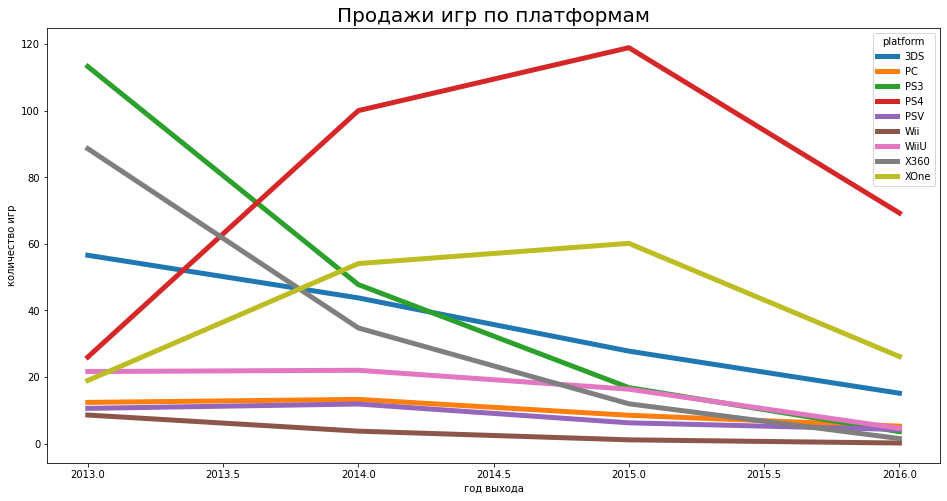

In [19]:

ax = (df_actual.pivot_table(index='year_of_release', 
                          columns='platform', 
                          values ='summ_sales', 
                          aggfunc='sum').
            plot(linewidth=5, 
                 figsize  =(16,8)))
ax.set(ylabel='количество игр',
       xlabel= 'год выхода')
ax.set_title('Продажи игр по платформам', fontsize=20)
plt.show;

**Вывод:**
По состоянию на 2016 год, актуальными остаются следующие игровын платформы: PS4, 3DS, XOne, WiiU, PS3, PC, X360, PSV, Wii.
- Платформы X360, PSV, Wii находятся на этапе завершения жизненного цикла. Делать на них ставку в будущем году бессмысленно. 
- PSV, WiiU находятся в середине жизненного цикла платформы, но хороших продаж они до сих пор не показали.
- Платформа PC не показывает больших продаж, однако не умирает уже три десятка лет. В бубущем, скорее всего будет также.
- PS4, XOne  появились недавно, и по логике, должны выходить в текущее время на пики продаж, но в последние два года, наоборот стагнируют. Их списывать со счетов ещё рано.
- 3DS также как и PS4, XOne относительно недавно появились, но продажи последние годы стабильно снижаются.


#### Анализ распределения выручки по глобальным продажам игр в разбивке по платформам. 

 Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

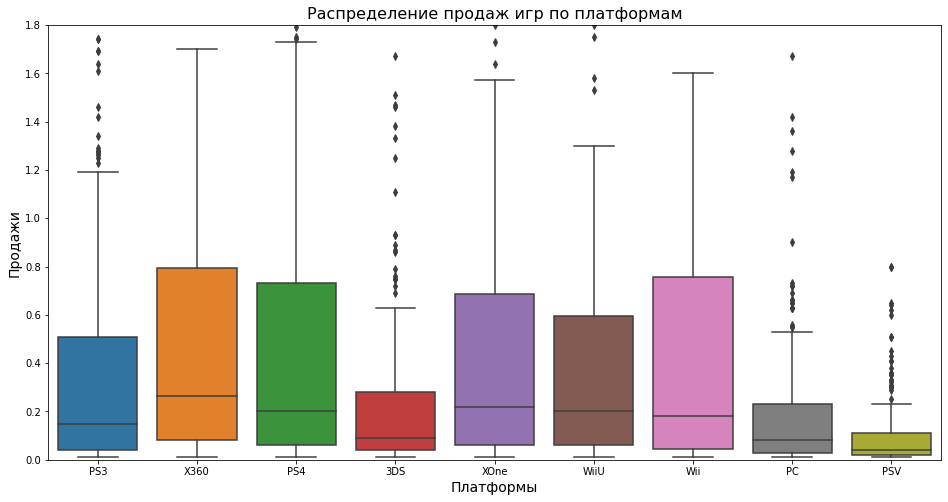

In [20]:
plt.figure(figsize=(16,8))
boxplot = sns.boxplot(data=df_actual, x='platform', y='summ_sales')
boxplot.axes.set_title("Распределение продаж игр по платформам", fontsize=16)
boxplot.set_xlabel("Платформы", fontsize=14)
boxplot.set_ylabel("Продажи", fontsize=14)

plt.ylim(0, 1.8)
plt.show()

**Вывод:**
По анализу графиков «ящик с усами» по платформам за актуальный период можно сгруппировать платформы по схожести их распределений продаж:
- X360, PS3, XOne, PS4 - продажи этих платформ схожи, так как данные платформы являются прямыми конкурентами, и XOne является новым поколением X360, а PS4 новым поколением PS3;
- Wii, WiiU - WiiU - новое поколение Wii;
- PC, PSV - схожи по характеру продаж, но различаются по сути;
- 3DS - стоит особняком, так как представленна, в основном, в Японии.

**Вывод**

В целом, начиная с 2008 года продажи игр на всех популярных платформах снижались. Связано это, скорее всего, с возрастающей распространённостью игр на мобильных устройствах, и переходом большего числа игроков на мобильные платформы. Этот сегмент, в данном исследовании не охвачен.
Исходя из вышеизложенного анализа, перспективной платформой в 2017 году, с некоторыми оговорками, можно считать только PS4, XOne, либо новую платформу, продажи которой начнутся только в 2017 году. Но, если бы в данном датасете были представленны данные по родажам игр на мобильных устройствах, то вывод был бы однозначен - необходимо делать ставку на мобильные платформы.

### Оценка влияния отзывов пользователей и критиков на продажи.

Для оценки влияния отзывов пользователей и критиков на продажи:

- Произведём оценку влияния отзывов пользователей и критиков на продажи внутри одной игровой платформы;
- Соотнесм выводы с продажами игр на других платформах.

#### Оценка влияния отзывов пользователей и критиков на продажи внутри одной популярной платформы.

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Для анализа выберем платформу из актуального периода, которая прошла весь жизненный цикл - X360. Для этого построим диаграмму рассеяния и рассчитаем корреляцию между отзывами и продажами. Для качественной оценки, перед началом анализа, произведём очистку данных от выбросов по продажам и отзывам. 

In [21]:
def moustache(col):
# Функция возвращает нижние и верхние усы диаграмы размаха     
    descr = col.describe()
    irq = (descr['75%'] - descr['25%']) * 1.5
    minimum = max(descr['25%'] - irq , descr['min'])
    maximum = min(descr['75%'] + irq, descr['max'])
    return minimum, maximum

Коэффициент кореляции продажи - отзывы пользователей = 0.15553969082922103
Коэффициент кореляции продажи - отзывы критиков = 0.4631353470186972


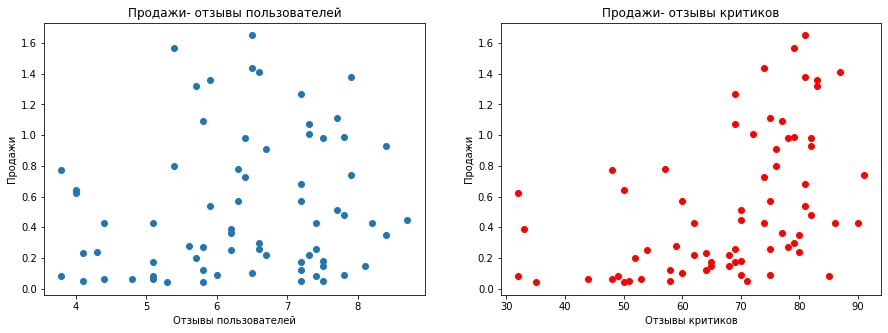

In [22]:
# выборка платформы и ОБРЕЗКА ПО УСАМ

# Выбор платформы
df_platform = df_actual[df_actual['platform'] == 'X360']
# Обрезка по усам
min_mus, max_mus = moustache(df_platform['summ_sales'])
df_platform = df_platform[(df_platform['summ_sales'] >= min_mus) & 
                          (df_platform['summ_sales'] <= max_mus)]
min_mus, max_mus = moustache(df_platform['user_score'])
df_platform = df_platform[(df_platform['user_score'] >= min_mus) & 
                          (df_platform['user_score'] <= max_mus)]
min_mus, max_mus = moustache(df_platform['critic_score'])
df_platform = df_platform[(df_platform['critic_score'] >= min_mus) & 
                          (df_platform['critic_score'] <= max_mus)]

print('Коэффициент кореляции продажи - отзывы пользователей =',df_platform['summ_sales'].corr(df_platform['user_score']))
print('Коэффициент кореляции продажи - отзывы критиков =',     df_platform['summ_sales'].corr(df_platform['critic_score']))

# Построение диаграмм рассеевыния
fig = plt.figure(figsize=(15,5))

ax_1 = fig.add_subplot(1, 2, 1)
ax_1.scatter(x = df_platform['user_score'], 
             y = df_platform['summ_sales'])
ax_1.set_title('Продажи- отзывы пользователей')
ax_1.set_xlabel("Отзывы пользователей")
ax_1.set_ylabel("Продажи")

ax_2 = fig.add_subplot(1, 2, 2)
ax_2.scatter(x = df_platform['critic_score'], 
             y = df_platform['summ_sales'], color='red')
ax_2.set(
       title = 'Продажи- отзывы критиков',
       xlabel = 'Отзывы критиков',
       ylabel = 'Продажи')
plt.show()


**Вывод:**
На примере игровой платформы X360, видно, что зависимость продаж от отзывов пользователей очень слабая, а от отзывов критиков несколько больше, но тоже имеет слабо выраженный характер. Для большей уверенности в сделанных выводах, произведём подобный анализ для других платформ.

#### Соотнесение выводов с продажами игр на других платформах. 

Построим диаграмму рассеяния и рассчитаем корреляцию между отзывами и продажами для остальных платформ из актуального периода. Для качественной оценки, перед началом анализа, произведём очистку данных от выбросов по продажам и отзывам.

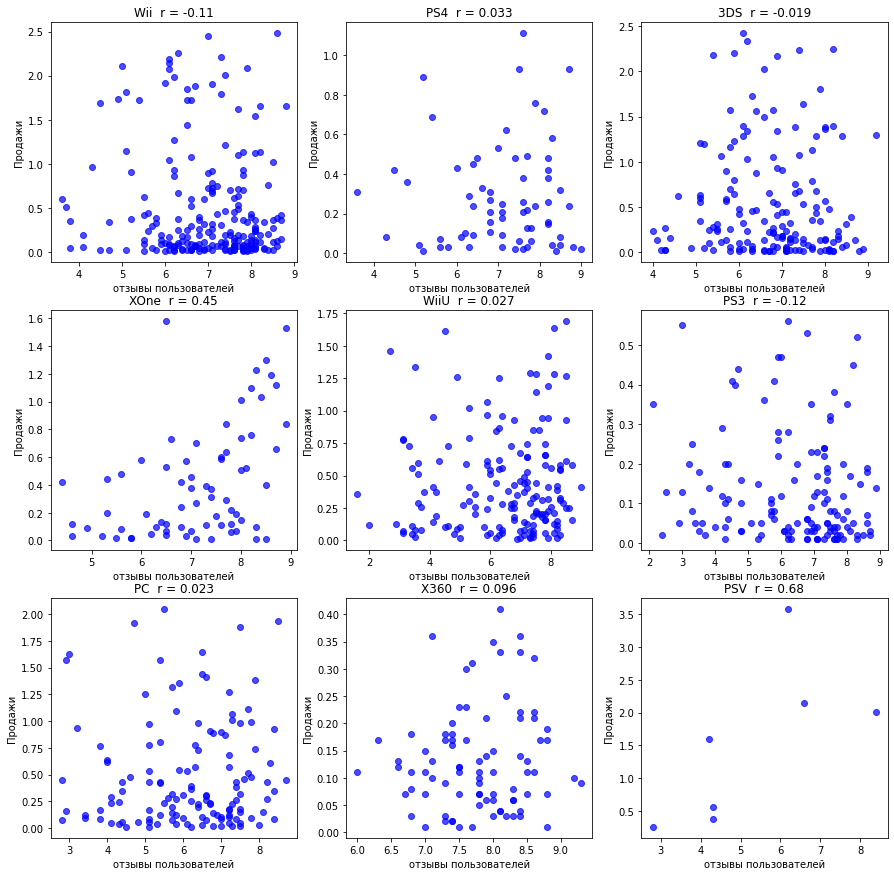

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,15))

n = 0

for ax in axes.flat:
    # Выборка данных для очередной платформы
    i_df_platform = df_actual[df_actual['platform'] == actual_platforms[n]]
    # Обрезка по усам
    min_mus, max_mus = moustache(i_df_platform['user_score'])
    i_df_platform = i_df_platform[(i_df_platform['user_score'] >= min_mus) & 
                                  (i_df_platform['user_score'] <= max_mus)]
    min_mus, max_mus = moustache(i_df_platform['summ_sales'])
    i_df_platform = i_df_platform[(i_df_platform['summ_sales'] >= min_mus) & 
                                  (i_df_platform['summ_sales'] <= max_mus)]
    # Расчёт кореляции
    r = i_df_platform['summ_sales'].corr(i_df_platform['user_score'])
    # Вывод графика
    ax.set(title=(f'{actual_platforms[n-1]}  r = {r:.2}'))
    ax.scatter(x = i_df_platform['user_score'],
               y = i_df_platform['summ_sales'],
               color='blue',
               alpha=0.7)
    ax.set(ylabel='Продажи', xlabel='отзывы пользователей')
    n += 1
plt.show()

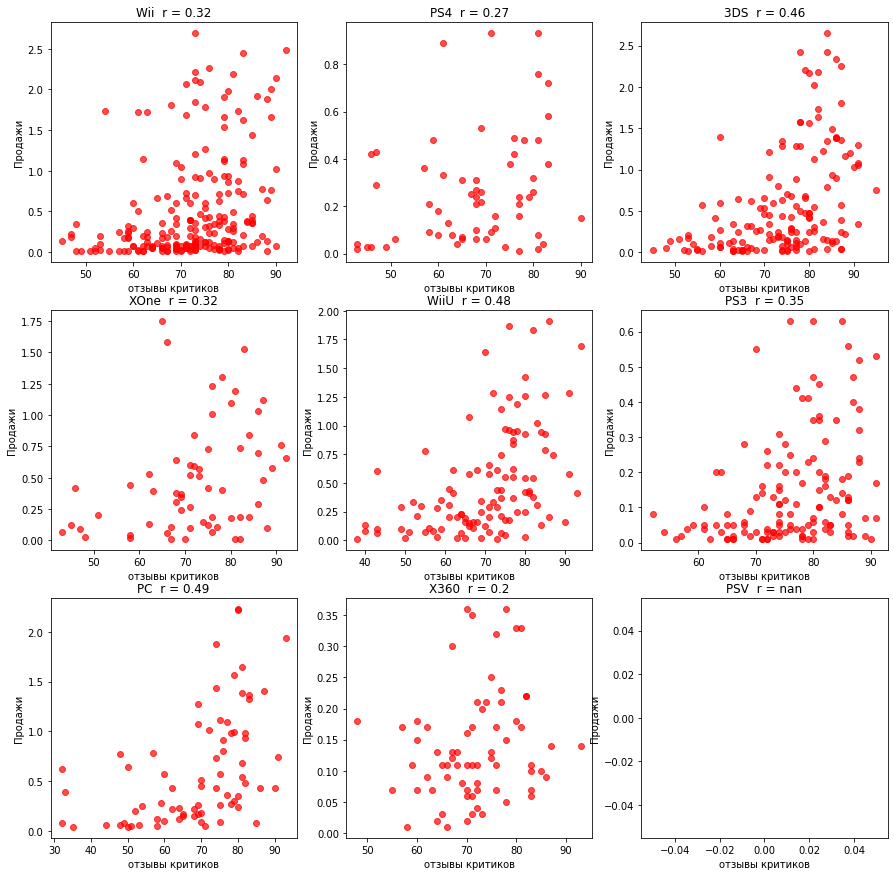

In [24]:
#fig = plt.figure(figsize=(15,15))
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,15))

n = 0

for ax in axes.flat:
    # Выборка данных для очередной платформы
    i_df_platform = df_actual[df_actual['platform'] == actual_platforms[n]]
    # Обрезка по усам
    min_mus, max_mus = moustache(i_df_platform['critic_score'])
    i_df_platform = i_df_platform[(i_df_platform['critic_score'] >= min_mus) & 
                                  (i_df_platform['critic_score'] <= max_mus)]
    min_mus, max_mus = moustache(i_df_platform['summ_sales'])
    i_df_platform = i_df_platform[(i_df_platform['summ_sales'] >= min_mus) & 
                                  (i_df_platform['summ_sales'] <= max_mus)]
     # Расчёт кореляции
    r = i_df_platform['summ_sales'].corr(i_df_platform['critic_score'])
    # Вывод графика
    ax.set(title=(f'{actual_platforms[n-1]}  r = {r:.2}'))
    ax.scatter(x = i_df_platform['critic_score'],
               y = i_df_platform['summ_sales'],
               color='red',
               alpha=0.7)
    ax.set(ylabel='Продажи', xlabel='отзывы критиков')
    n += 1
plt.show()

**Вывод:**
Проанализировав актуальные на 2016 год платформы, можно сделать вывод, что наши выводы по платформе X360 оказались верны. По остальным платформам кореляция продаж и отзывов пользователей практически отсутствует. Кореляция продаж с оценками критиков немного сильнее. 

**Вывод**

- Влияние отзывов пользователей на продажи практически отсутствует. 
- Влияние отзывов критиков на продажи немного сильнее. 

Такое положение дел, наиболее вероятно, сложилось потому что пользователи купив игру уже проголосовали за не рублём. Ведь чтобы поставить оценку, пользователю необходимо сначала купить игру. Но её не купят те, кому она совсем не нравтся. Отсюда и отсутствие связи между продажами и оценками пользователей. С оценками критиков, картина немного другая. Критики более объективны в своих оценках. Отсюда и более сильная кореляция продаж и их оценок. Однако, очевидно, что продажи двигают вверх не оценки пользователей и критиков, а како-то другой параметр, выходящий за рамки данного исследования. Возможно это размер бюджета рекламной компании, или популярность самой игровой платформы.

### Анализ распределеня игр по жанрам.

Проанализируем общее распределение игр по жанрам. 
- Что можно сказать о самых прибыльных жанрах? 
- Выделяются ли жанры с высокими и низкими продажами?

Для ответов на эти вопросы произведём группировку игр по жанрам с рассчётом количества игр, суммарных продаж и продаж на одну игру.

In [25]:
# Сводная таблица с расчётами
df_genre = df_actual.pivot_table(index = 'genre', values='name', aggfunc='count').sort_values(by='name', ascending=False)
df_genre = df_genre.merge(df.pivot_table(index = 'genre', values='summ_sales', aggfunc='sum'), on='genre')
df_genre['sales_game'] = df_genre['summ_sales'] / df_genre['name']
df_genre

,name,summ_sales,sales_game
genre,,,
Action,752,"1,744.17",2.32
Role-Playing,285,934.56,3.28
Adventure,211,237.59,1.13
Sports,208,"1,331.27",6.40
Shooter,187,"1,052.45",5.63
Misc,146,802.51,5.50
Racing,85,728.67,8.57
Fighting,79,447.53,5.66
Platform,72,827.77,11.50


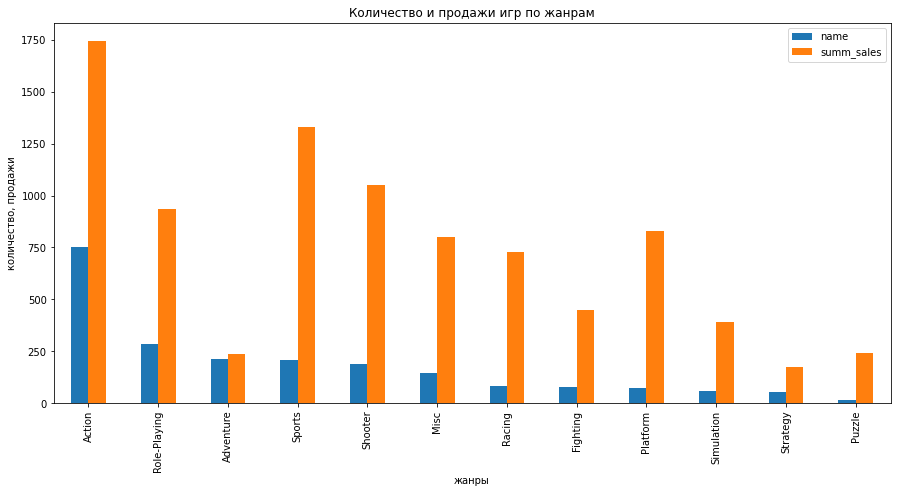

In [26]:
# График зависимости Количество и продажи игр по жанрам
ax = df_genre[['name','summ_sales']].plot(kind='bar', 
                                     figsize=(15,7), 
                                     title='Количество и продажи игр по жанрам')
ax.set(ylabel='количество, продажи',
       xlabel= 'жанры')
plt.show;

На графике видно, что количество проданых игр, и суммарные продажи не всегда находятся в прямой зависимости. Для определения ценности игр построим график продаж на одну игру по жанрам.

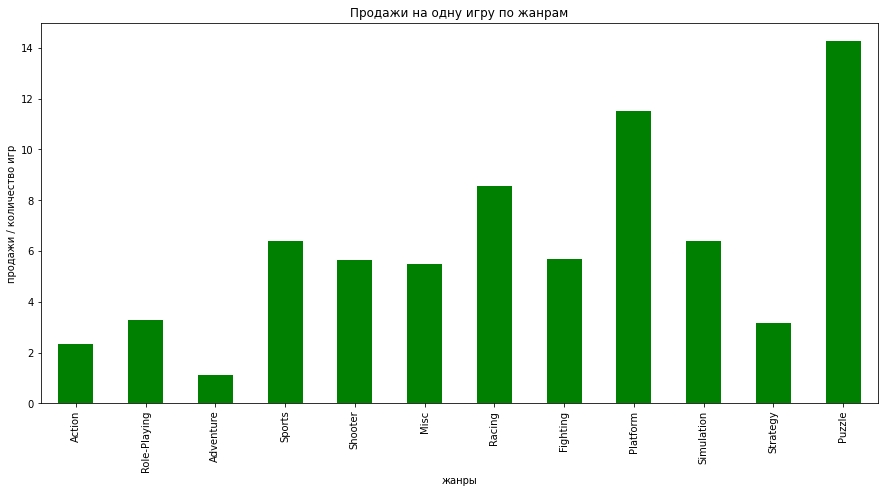

In [27]:
# График зависимости продаж на одну игру по жанрам
ax = df_genre['sales_game'].plot(kind='bar', 
                              figsize=(15,7), 
                                title='Продажи на одну игру по жанрам',
                                color='green')
ax.set(ylabel='продажи / количество игр',
       xlabel= 'жанры')
plt.show;

**Вывод**

Самые продаваемые жанры игр: action, sport и shooter. Из диаграммы, мы видим, что продажи по жанрам прямопропорциональны количеству игр этого жанра. Наиболее эффективными с точки зрения выручки на одну игру являются игры жанров puzzle и platform.

**Вывод по разделу**

- Актуальный период определён как среднее время жизни игровой платформы - 12 лет. Из дальнейшего анализа, также, исключили игровые платформы не актуальные на 2016 год.

- В целом, начиная с 2008 года продажи игр на всех популярных платформах снижались. Связано это, скорее всего, с возрастающей распространённостью игр на мобильных устройствах, и переходом большего числа игроков на мобильные платформы.
- Перспективной платформой в 2017 году, с некоторыми оговорками, можно считать только PS4, XOne, либо новую платформу, продажи которой начнутся только в 2017 году. Но, если бы в данном датасете были представленны данные по родажам игр на мобильных устройствах, то вывод был бы однозначен - необходимо делать ставку на мобильные платформы.

- Самые продаваемые жанры игр: action, sport и shooter. Наиболее эффективными с точки зрения выручки на одну игру являются игры жанров platform.

## Составление портрета пользователя каждого региона

Определим для пользователя каждого региона (NA, EU, JP):
- Самые популярные платформы (топ-5). Опишите различия в долях продаж.
- Самые популярные жанры (топ-5). Поясните разницу.
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

### Определение популярности игровых платфор в регионах

Для решения данной задачи построим столбчатую диаграмму распределения продаж по регионам и платформам. 

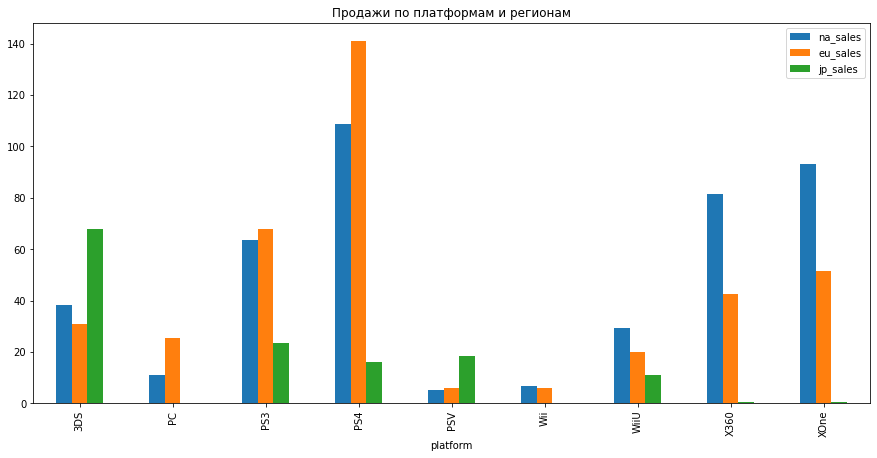

In [28]:
# Сводная таблица 
df_region_platform = df_actual.pivot_table(index = 'platform', values=['na_sales','eu_sales','jp_sales'], aggfunc='sum')
# Поменяем порядок колонок для наглядности
df_region_platform = df_region_platform.reindex(columns=['na_sales','eu_sales','jp_sales'])
df_region_platform.plot(kind='bar', figsize=(15,7), title='Продажи по платформам и регионам');

На графике видно, что в разных регионах, пользуются популярностью разные игровые платформы. Для удоства определения топ 5 популярных платформ, построим такиеже графики отдельно для каждого региона и отсортруем значения в них.  


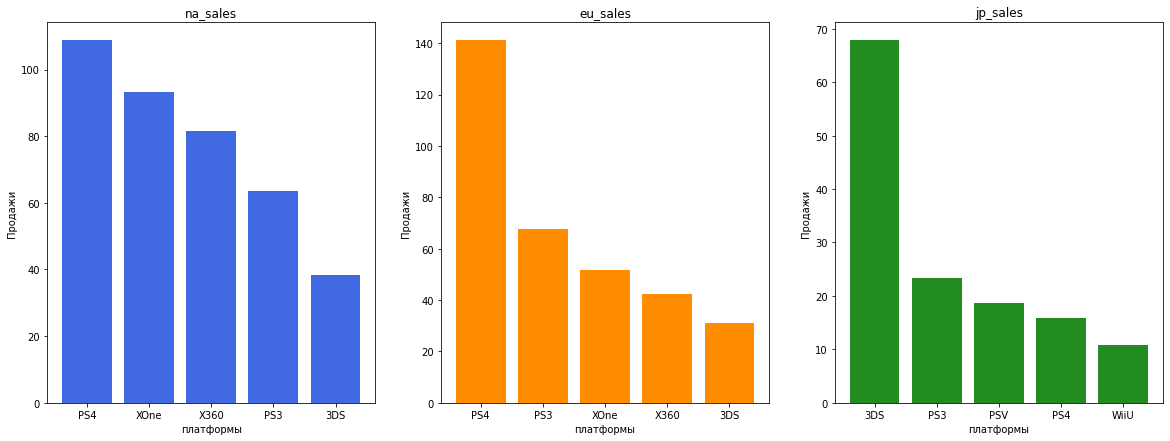

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,7))

n = 0
colors = ['royalblue','darkorange','forestgreen']
for ax in axes:
    i_df = df_region_platform[df_region_platform.columns[n]].sort_values(ascending=False).head()
    ax.bar(i_df.index,i_df, color=colors[n])
    ax.set(title=(df_region_platform.columns[n]), ylabel='Продажи', xlabel='платформы') 
    n += 1
plt.show()

Топ 5 платформ по регионам:
- Северная америка: PS4, XOne, X360, PS3, 3DS;
- Европа: PS4, PS3, XOne, X360, 3DS;
- Япония: 3DS, PS3,  PSV, PS4, WiiU.

**Вывод**

Топ 5 платформ для рынка игр северной америки и европы совпадают. В Японии предпочтения игроков отличаются от остальных регионов более значительно. Отличия в двух платформах из топ-5. Это объясняется большой популярностью в Японии портативных игровых платформ(PSV, WiiU).

### Определение популярности игровых жанров в регионах

Для решения данной задачи построим столбчатую диаграмму распределения продаж по регионам и игровым жанрам.

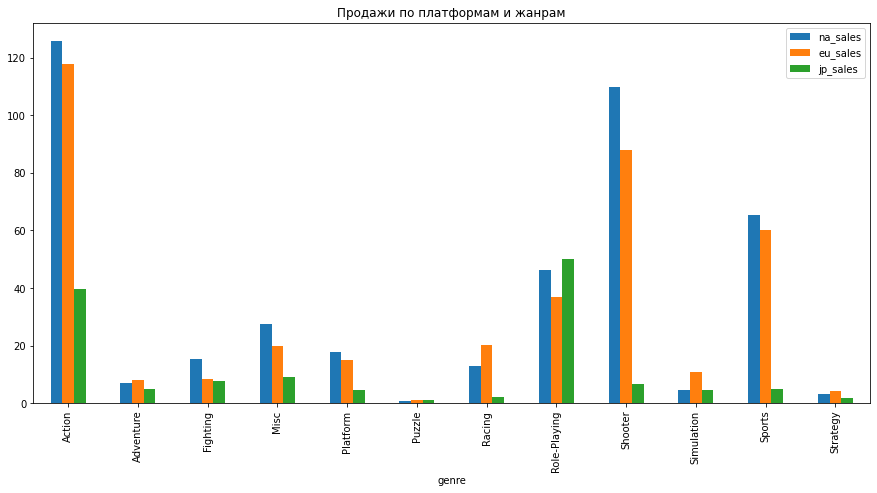

In [30]:
# Сводная таблица 
df_region_genre = df_actual.pivot_table(index = 'genre', values=['na_sales','eu_sales','jp_sales'], aggfunc='sum')
# Поменяем порядок колонок для наглядности
df_region_genre = df_region_genre.reindex(columns=['na_sales','eu_sales','jp_sales'])
df_region_genre.plot(kind='bar', figsize=(15,7), title='Продажи по платформам и жанрам');

На графике видно, что в разных регионах, пользуются популярностью разные игровые жанры. Для удоства определения топ 5 популярных игровых жанров, построим такиеже графики отдельно для каждого региона и отсортруем значения в них.

['Action', 'Shooter', 'Sports', 'Role-Playing', 'Misc']

['Action', 'Shooter', 'Sports', 'Role-Playing', 'Racing']

['Role-Playing', 'Action', 'Misc', 'Fighting', 'Shooter']

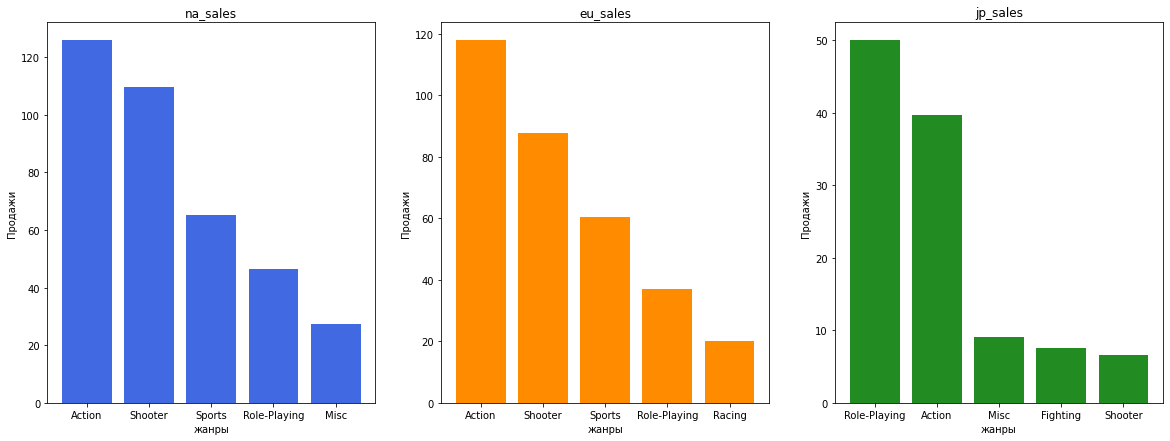

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,7))

n = 0
colors = ['royalblue','darkorange','forestgreen']
for ax in axes:
    i_df = df_region_genre[df_region_genre.columns[n]].sort_values(ascending=False).head()
    display(list(i_df.index))
    ax.bar(i_df.index,i_df, color=colors[n])
    ax.set(title=(df_region_platform.columns[n]), ylabel='Продажи', xlabel='жанры')
    ax.set
    n += 1
plt.show()

Топ 5 игровых жанров по регионам:

- Северная америка: Action, Shooter, Sports, Role-Playing, Misc;
- Европа: Action, Shooter,  Sports, Role-Playing, Racing;
- Япония: Role-Playing, Action, Misc, Figthing, Shooter.

**Вывод**

Топ 5 жанров игр для рынка северной америки и европы отличаются только на одну(пятую) позицию. Топ-4 в данных регионах совпадают. Пятую позицию в этих регионах занимаеют другие жанры и гонки соответственно. В Японии предпочтения игроков отличаются от остальных регионов более значительно. Отличия в двух платформах из топ-5. В японии больше всего любят ролевые игры. В топ-5, также входят игры жанра Figthing.

### Влияние рейтина ESRB на продажи

Влияет ли рейтинг ESRB на продажи в отдельном регионе?

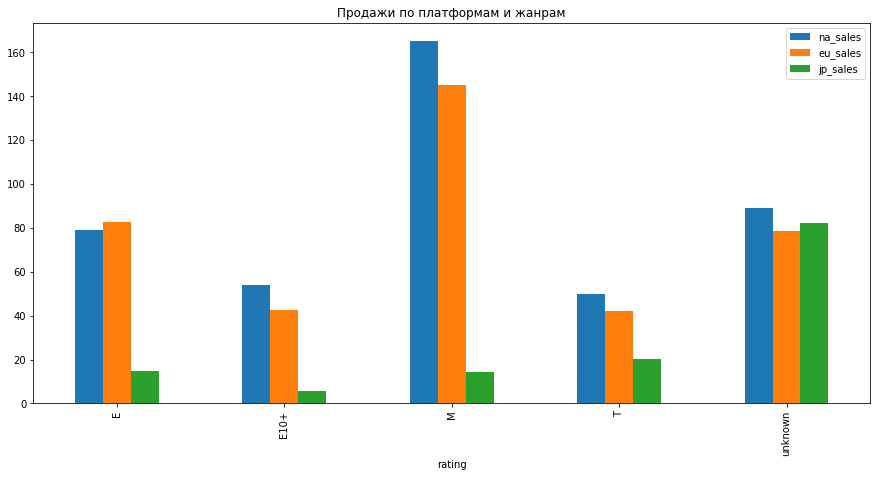

In [32]:
# Сводная таблица 
df_region_rating = df_actual.pivot_table(index = 'rating', values=['na_sales','eu_sales','jp_sales'], aggfunc='sum')
# Поменяем порядок колонок для наглядности
df_region_rating = df_region_rating.reindex(columns=['na_sales','eu_sales','jp_sales'])
df_region_rating.plot(kind='bar', figsize=(15,7), title='Продажи по платформам и жанрам');

По такому графику трудно оценить отличия продаж по регионам в зависимости от рейтинга игр. Произведём расчёт доли продаж для каждого региона в зависисмости от рейтинга.

In [33]:
# Расчёт доли продаж по рейтингу для каждого региона
df_region_rating['na_percent'] = df_region_rating['na_sales']/df_region_rating['na_sales'].sum()
df_region_rating['eu_percent'] = df_region_rating['eu_sales']/df_region_rating['eu_sales'].sum()
df_region_rating['jp_percent'] = df_region_rating['jp_sales']/df_region_rating['jp_sales'].sum()

In [34]:
df_region_rating

,na_sales,eu_sales,jp_sales,na_percent,eu_percent,jp_percent
rating,,,,,,
E,78.94,82.80,15.00,0.18,0.21,0.11
E10+,54.02,42.53,5.89,0.12,0.11,0.04
M,165.21,145.32,14.11,0.38,0.37,0.10
T,49.79,41.95,20.44,0.11,0.11,0.15
unknown,89.18,78.61,82.05,0.20,0.20,0.60


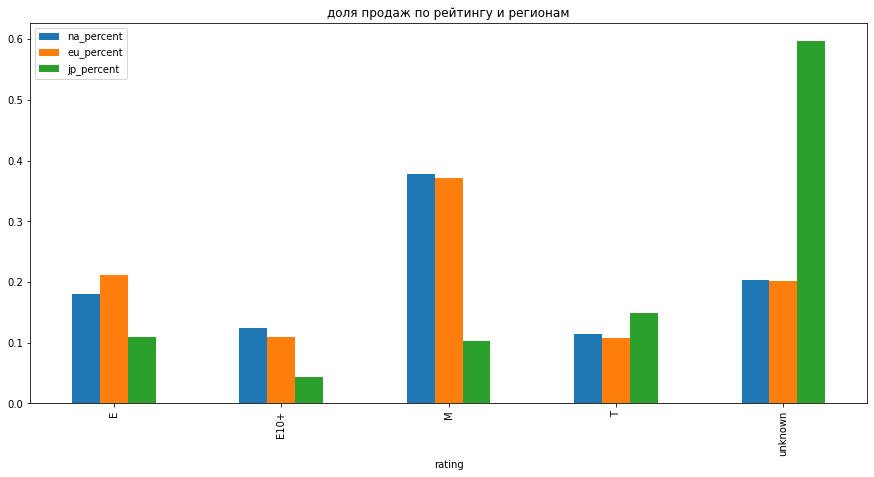

In [35]:
(df_region_rating[['na_percent','eu_percent','jp_percent']]
     .plot(kind='bar', figsize=(15,7), title='доля продаж по рейтингу и регионам'));

**Вывод**

В европе и северной америке предпочтения игр по рейтингу схожи. В Японии больше покупают игр с рейтингом T,  меньше игр с рейтингом M. Однако, доля продаж игр с неопределённым рейтингом в Японии значительно превосходит долю продаж игр с неопределённым рейтиногом в европе и америке вместе взятых. Это может означать, что больше половины игр продаваемых в Японии не получают рейтинг ESRB. У них есть своё рейтинговое агенство CERO, данные которого отсутствуют в датасете. Таким образом, оценить предпочтения японских игроков по рейтингу игр не представляется возможным.

**Вывод по разделу**

Предпочтения игроков по игровым платформам, жанрам игр и категориям игр по рейтингу ESRB схожи для северной америки и европы, а для Японии значительно отличаются.

## Проверьте гипотезы

Проверим следующие гипотезы:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action и Sports разные.

### Проверка гипотезы "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые."


Сформулируем нулевую и альтернативную гипотезы:
- Нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC равны.
- Альтернативная гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC различаются.

Для лучшего представления распределения сравниваемых выборок, сначала построим гистограммы. Затем, для принятия нулевой или альтернативной гипотезы, применим t-тест к выборкам.  Статистическую значимость примем равной 5%.

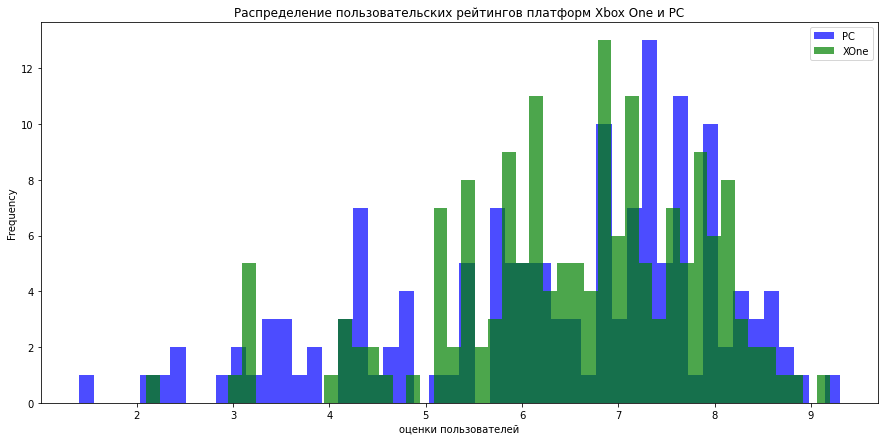

Средние оценки ползователей платформы PC: 6.3020270270270276
Средние оценки ползователей платформы X-box One: 6.538181818181818


In [36]:
# Выборки по платформам выделим в отдельные таблицы
df_xone = df_actual[df_actual['platform'] == 'XOne'].dropna()
df_pc   = df_actual[df_actual['platform'] == 'PC' ].dropna()

# Построение гистограмм    
ax = df_pc.plot(  y    ='user_score',
                  kind ='hist',
                  color='blue',
                  alpha=0.7,
                  label='PC',
                  bins =50)
ax.set_xlabel('оценки пользователей')
(df_xone.plot(  y      ='user_score',
                ax     =ax,
                kind   ='hist',
                color  ='green',
                alpha  =0.7,
                label  ='XOne',
                title  ='Распределение пользовательских рейтингов платформ Xbox One и PC',
                bins   =50,
                figsize=(15,7)))
plt.show()

print('Средние оценки ползователей платформы PC:', df_pc['user_score'].mean())
print('Средние оценки ползователей платформы X-box One:',df_xone['user_score'].mean())


In [37]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(df_xone['user_score'],
                       df_pc['user_score'],
                       equal_var = False)
 
print('p-значение: ', results.pvalue)

# если p-value окажется меньше него - отвегнем гипотезу
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.17882648263401307
Не получилось отвергнуть нулевую гипотезу


**Вывод**

Нулевая гипотеза подтверждена: Средние пользовательские рейтинги платформ Xbox One и PC равны.

### Проверка гипотезы: "Средние пользовательские рейтинги жанров Action и Sports  разные.

Сформулируем нулевую и альтернативную гипотезы:
- Нулевая гипотеза: Средние пользовательские рейтинги жанров Action и Sports равны.
- Альтернативная гипотеза: Средние пользовательские рейтинги жанров Action и Sports различаются.

Для лучшего представления распределения сравниваемых выборок, сначала построим гистограммы. Затем, для принятия нулевой или альтернативной гипотезы, применим t-тест к выборкам.  Статистическую значимость примем равной 5%.

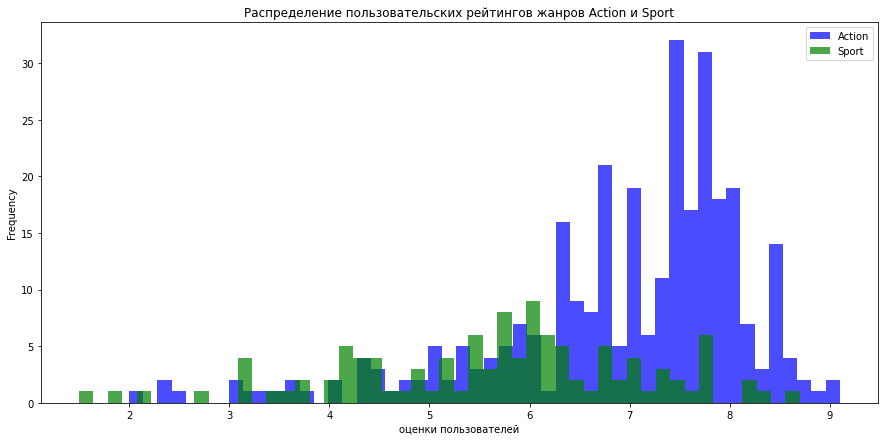

Средние оценки ползователей рейтинги жанра Action: 6.9362459546925574
Средние оценки ползователей рейтинги жанра Sport: 5.665454545454545


In [38]:
# Выборки по платформам выделим в отдельные таблицы
df_action = df_actual[df_actual['genre'] == 'Action'].dropna()
df_sport  = df_actual[df_actual['genre'] == 'Sports' ].dropna()

# Построение гистограмм    
ax = df_action.plot(y    ='user_score',
                  kind ='hist',
                  color='blue',
                  alpha=0.7,
                  label='Action',
                  bins =50)
ax.set_xlabel('оценки пользователей')
(df_sport.plot(y      ='user_score',
            ax     =ax,
            kind   ='hist',
            color  ='green',
            alpha  =0.7,
            label  ='Sport',
            title  ='Распределение пользовательских рейтингов жанров Action и Sport',
            bins   =50,
            figsize=(15,7)))
plt.show()

print('Средние оценки ползователей рейтинги жанра Action:', df_action['user_score'].mean())
print('Средние оценки ползователей рейтинги жанра Sport:',df_sport['user_score'].mean())

In [39]:
alpha = .05 # критический уровень статистической значимости

results = st.ttest_ind(df_action['user_score'],
                       df_sport['user_score'],
                       equal_var = False)
 
print('p-значение: ', results.pvalue)

# если p-value окажется меньше него - отвегнем гипотезу
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  1.0496920005008588e-13
Отвергаем нулевую гипотезу


**Вывод**

Отвергаем нулевую гипотезу, принимаем альтернативную: Средние пользовательские рейтинги жанров Action и Sports разные.

**Вывод по разделу**

- Гипотеза "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые" - подтверждена;
- Гипотеза "Средние пользовательские рейтинги жанров Action и Sports разные" - отвергнута.


## Вывод по проекту

1. На этапах загрузки и подготовки данных произвели переименование колонок, преобразование типов данных, обработку пропусков и расчёт сумарных продаж.
2. В ходе исследовательского анализа данных определили:
    - Актуальный период для дальнейшего анализа;
    - Перспективной платформой в 2017 году, можно считать только PS4, XOne, либо новую платформу, продажи которой начнутся только в 2017 году. Наиболее вероятно, необходимо делать ставку на игры на мобильных телефонах;
    - Отзывы пользователей не влияют на продажи. Отзывы критиков влияют, но не очень сильно;
    - Самые продаваемые жанры игр: action, sport и shooter. Наиболее эффективными с точки зрения выручки на одну игру являются игры жанров platform.
3. По результатам составления портрета пользователя по регионам, можно сказать, что игроки северной америки и европы схожи в своих предпочтениях игровых платформ и жанров игр. Игроки из Японии значительно отличаются.
4. При приверке гипотез зделаны следующие выводы:
    - Гипотеза "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые" - подтверждена;
    - Гипотеза "Средние пользовательские рейтинги жанров Action и Sports разные" - отвергнута.
    
Главный вывод, который можно сделать по результатам анализа, это то, что в 2017 году перспективными игровыми платформами можно считать только PS4, XOne. Однако, продажи игр в сегменте игровых платформ падают на протяжении последних восьми лет. Выход новых игровых платформ ситуацию не меняет. Это связано, скорее всего, с переходом пользователей на игры на мобильных телефонах. По крайней мере это справедливо для портативных игровых платформ.  Поэтому интернет магазину «Стримчик», в 2017 году, необходимо направить рекламный бюджет на стационарные игровые платформы PS4 и XOne, а с портативных ировых платформ, переориентировать бизнес на продажу игр для мобильных телефонов. Как это сделать, с учётом того, что большинство игр для мобильных телефонов продаются с помощью AppleStore и GooglePlay - тема отдельного исследования. 
